<b><u>Contributor</u></b>: Dimitris Vougioukos - f3352411

The following is the implementation of the exercise 9 of the second assignment of the Text Analytics course on text classification with Multi-Layer Perceptrons (MLPs)

### **Exercise 9**

Import and download some required packages

In [ ]:
# Importing required libraries
import random
import nltk
import gensim.downloader as api
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import movie_reviews, stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    classification_report,
    accuracy_score,
)
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate


# Downloading NLTK datasets
nltk.download("movie_reviews")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Explore the `movie_reviews` dataset

In [ ]:
# Getting all the file ids
file_ids = movie_reviews.fileids()

print(f"Five random file ids of the dataset:\n {random.sample(file_ids, 5)}\n")

# Getting the distinct classes
categories = movie_reviews.categories()


print(f"The distinct classes of the reviews:\n {categories} \n")
print(f"The number of positive reviews is: {len(movie_reviews.fileids('pos'))} \n")
print(f"The number of negative reviews is: {len(movie_reviews.fileids('neg'))}")

Five random file ids of the dataset:
 ['neg/cv171_15164.txt', 'pos/cv374_25436.txt', 'neg/cv000_29416.txt', 'neg/cv435_24355.txt', 'pos/cv846_29497.txt']

The distinct classes of the reviews:
 ['neg', 'pos'] 

The number of positive reviews is: 1000 

The number of negative reviews is: 1000


Retrieve the raw text of each review and its corresponding category

In [ ]:
# Initializing two lists to keep the raw text of each review and its category
reviews_text = []
reviews_category = []

# Iterating over the review categories
for category in categories:

    # Iterating over the file ids of the current category
    for file_id in movie_reviews.fileids(category):

        # Updating the lists
        reviews_text.append(movie_reviews.raw(file_id))
        reviews_category.append(1 if category == "pos" else 0)

Pre-process the reviews

In [ ]:
# Setting the stopwords
stopwords = stopwords.words("english")

# Initializing a lemmatizer
lemmatizer = WordNetLemmatizer()

# Initializing a list to keep the tokenized reviews
tokenized_reviews_text = []

# Iterating over the reviews
for review_text in reviews_text:

    # Initializing a list to keep the tokens of the current review
    tokenized_review_text = []

    # Getting the sentences of the current review
    sentences = sent_tokenize(review_text)

    # Iterating over the sentences
    for sentence in sentences:

        # Applying word level tokenization
        words = word_tokenize(sentence)

        # Iterating over the tokens/words
        for word in words:

            # Checking whether to keep or not the token
            if word.isalnum() and word not in stopwords:

                # Updating
                tokenized_review_text.append(lemmatizer.lemmatize(word.strip().lower()))

    # Updating
    tokenized_reviews_text.append(tokenized_review_text)

print(
    f"The average review length is: {round(sum(len(tokenized_review) for tokenized_review in tokenized_reviews_text) / len(tokenized_reviews_text), 0)} tokens"
)

The average review length is: 342.0 tokens


Split dataset into training, validation and test datasets

In [ ]:
# Splitting the dataset into training and test datasets
reviews_training, reviews_test, categories_training, categories_test = (
    train_test_split(
        tokenized_reviews_text,
        reviews_category,
        test_size=0.2,
        random_state=42,
        stratify=reviews_category,
    )
)

# Splitting the training dataset into training and development datasets
reviews_training, reviews_validation, categories_training, categories_validation = (
    train_test_split(
        reviews_training,
        categories_training,
        test_size=0.3,
        random_state=42,
        stratify=categories_training,
    )
)

print(f"The number of reviews in the training dataset is: {len(reviews_training)}")
print(f"The number of reviews in the validation dataset is: {len(reviews_validation)}")
print(f"The number of reviews in the test dataset is: {len(reviews_test)}")

The number of reviews in the training dataset is: 1120
The number of reviews in the validation dataset is: 480
The number of reviews in the test dataset is: 400


Download Word2Vec embeddings trained on Google news dataset

In [ ]:
# Getting the Word2Vec embeddings
word2vec_embeddings = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Define a function to find the Word2Vec embeddings of a specific set of reviews

In [ ]:
def find_word2vec_embeddings(reviews, word2vec_embeddings):
    """
    This function is used to get the Word2Vec embeddings for a set of reviews.

    :param reviews: A set of reviews
    :param word2vec_embeddings: The Word2Vec embeddings
    :return: A list of Word2Vec embeddings
    """

    # Initializing a list to keep the embeddings
    reviews_embedding = []

    # Iterating over the reviews
    for review in reviews:

        # Initializing a list to keep the embedding of the current review
        review_embedding = []

        # Iterating over the words/tokens of the current review
        for word in review:

            # Checking whether there is a word2vec word embedding
            if word in word2vec_embeddings:

                # Updating
                review_embedding.append(word2vec_embeddings[word])

        # Checking whether any word embedding was found
        if review_embedding == []:

            # Create a vector of 300 zero values
            review_embedding = np.zeros(word2vec_embeddings.vector_size)

        else:

            # Getting the centroid of all the word embeddings
            review_embedding = np.mean(review_embedding, axis=0)

        # Updating
        reviews_embedding.append(review_embedding)

    return np.array(reviews_embedding)

Produce the different representations of the texts of the reviews

In [ ]:
# Getting the TF-IDF representation of the reviews


# Initializing the vectorizer
vectorizer = TfidfVectorizer(max_features=2000, sublinear_tf=True)

# Getting the join of the tokens of each review
joined_reviews_training = [" ".join(review) for review in reviews_training]
joined_reviews_validation = [" ".join(review) for review in reviews_validation]
joined_reviews_test = [" ".join(review) for review in reviews_test]

# Converting reviews into TF-IDF representation
reviews_training_tfidf = vectorizer.fit_transform(joined_reviews_training).toarray()
reviews_validation_tfidf = vectorizer.fit_transform(joined_reviews_validation).toarray()
reviews_test_tfidf = vectorizer.fit_transform(joined_reviews_test).toarray()


# Getting the Word2Vec embeddings of the reviews

reviews_training_word2vec = find_word2vec_embeddings(
    reviews_training, word2vec_embeddings
)
reviews_validation_word2vec = find_word2vec_embeddings(
    reviews_validation, word2vec_embeddings
)
reviews_test_word2vec = find_word2vec_embeddings(
    reviews_test, word2vec_embeddings
)

Define a MLP classifier

In [ ]:
class MLPClassifier(nn.Module):
    """
    This class is used to define an MLP classifier.
    """


    def __init__(
        self, input_dimension, hidden_layers, dropout_prob, batch_normal, layer_normal
    ):
        """
        This is the constructor of the MLP classifier

        :param input_dimension: The input layer size
        :param hidden_layers: List of integers specifying the number of neurons in each hidden layer
        :param dropout_prob: The dropout probability
        :param batch_normal: The batch normalization boolean flag
        :param layer_normal: The layer normalization boolean flag
        """

        # Calling the constructor of the super class
        super(MLPClassifier, self).__init__()

        # Setting a list keeping layers parameters
        total_layers = []

        # Setting the dimension of the first layer (input layer)
        prev_layer_dimension = input_dimension

        # Checking whether there are hidden layers to add
        if hidden_layers:

            # Iterating over the hidden layers
            for hidden_layer in hidden_layers:

                # Adding the hidden layer with the specified dimension (number of neurons)
                total_layers.append(nn.Linear(prev_layer_dimension, hidden_layer))

                # Setting a ReLU activation function for the hidden layer's neurons
                total_layers.append(nn.ReLU())

                # Checking to add dropout or not
                if dropout_prob > 0:

                    # Adding dropout
                    total_layers.append(nn.Dropout(dropout_prob))

                # Checking to add batch normalization or not
                if batch_normal:

                    # Adding batch normalization
                    total_layers.append(nn.BatchNorm1d(hidden_layer))

                # Checking to add layer normalization or not
                if layer_normal:

                    # Adding layer normalization
                    total_layers.append(nn.LayerNorm(hidden_layer))

                # Updating the last layer's dimension
                prev_layer_dimension = hidden_layer

        # Adding the ouput layer consisting of one neuron
        total_layers.append(nn.Linear(prev_layer_dimension, 1))

        # Setting a Sigmoid activation function
        total_layers.append(nn.Sigmoid())

        # Creating a sequential neural network based on the layers
        self.model = nn.Sequential(*total_layers)


    def forward(self, x):

        return self.model(x)

Define a function to train the MLP classifier

In [ ]:
def train_mlp_classifier(
    mlp_classifier, epochs, training_loader, validation_loader, learning_rate, classifier_count
):
    """
    This function is used to train an MLP classifier.

    :param mlp_classifier: The MLP classifier
    :param epochs: The number of epochs
    :param training_loader: The training loader
    :param validation_loader: The validation loader
    :param learning_rate: The learning rate of the optimizer
    :param classifier_count: The number of the current classifier
    :return: The training and validation losses and the path of the best classifier
    """

    # Initializing two lists to keep the training ans validation losses across epochs
    training_losses, validation_losses = [], []

    # Initializing a variable to keep the lowest validation loss across epochs
    best_validation_loss = float("inf")

    # Setting a variable to hold the path of the best classifier
    best_classifier_path = None

    # Setting the loss function
    criterion = nn.BCELoss()

    # Setting the optimizer
    optimizer = optim.Adam(mlp_classifier.parameters(), lr=learning_rate)

    # Setting the epochs patience before early stopping
    patience = 3

    # Initializing a variable counting the epochs until early stopping
    early_stopping_counter = 0

    # Iterating over the epochs
    for epoch in range(1, epochs + 1):

        # Setting the model in training mode
        mlp_classifier.train()

        # Initializing a varibable to keep the epoch's training loss
        training_loss = 0

        # Iterating over the training batches
        for train_reviews, train_categories in training_loader:

            # Initializing the optimizer
            optimizer.zero_grad()

            # Predicting
            predicted_train_categories = mlp_classifier(train_reviews)

            # Computing the criterion loss (function loss)
            criterion_loss = criterion(
                predicted_train_categories, train_categories.unsqueeze(1).float()
            )

            # Applying backpropagation - Computing loss gradients
            criterion_loss.backward()

            # Updating the weights
            optimizer.step()

            # Updating the training loss
            training_loss += criterion_loss.item()

        # Getting the final training loss of the epoch
        training_loss = training_loss / len(training_loader)

        # Updating
        training_losses.append(training_loss)

        # Setting the model in evaluation mode
        mlp_classifier.eval()

        # Initializing a varibable to keep the epoch's validation loss
        validation_loss = 0

        # Without using the gradient computations
        with torch.no_grad():

            # Iterating over the validation batches
            for val_reviews, val_categories in validation_loader:

                # Predicting
                predicted_val_categories = mlp_classifier(val_reviews)

                # Computing the loss
                criterion_loss = criterion(
                    predicted_val_categories, val_categories.unsqueeze(1).float()
                )

                # Updating the validation loss
                validation_loss += criterion_loss.item()

        # Getting the final validation loss of the epoch
        validation_loss = validation_loss / len(validation_loader)

        # Updating
        validation_losses.append(validation_loss)

        # Checking to show the current losses
        if epoch % 5 == 0:

            print(
                f"Epoch: {epoch} / {epochs} | Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}"
            )

        # Checking if we have a better validation loss
        if validation_loss < best_validation_loss:

            # Updating
            early_stopping_counter = 0

            # Updating best validation loss
            best_validation_loss = validation_loss

            # Checking whether a previous best model exists
            if best_classifier_path is not None:

                # Deleting
                os.remove(best_classifier_path)

            # Updating the new best classifier path
            best_classifier_path = (
                f"best_classifier_{classifier_count}_epoch_{epoch}.pth"
            )

            # Saving the best classifier
            torch.save(mlp_classifier.state_dict(), best_classifier_path)

        else:

            # Updating
            early_stopping_counter += 1

            # Checking if early stopping is going to be triggered
            if early_stopping_counter >= patience:

                print(f"\nEarly stopping at epoch {epoch}")

                break

    return training_losses, validation_losses, best_classifier_path

Define a function to compute the classification scores of a classifier

In [ ]:
def compute_classification_scores(ground_truth, category_predictions, prob_predictions):
    """
    This function is used to compute the classification scores of a classifier.

    :param ground_truth: The actual categories
    :param category_predictions: The predicted categories
    :param prob_predictions: The predicted probabilities
    :return: The classification scores
    """

    # Computing the precision, recall and f1 scores
    classification_scores = classification_report(
        ground_truth,
        category_predictions,
        target_names=["neg", "pos"],
        output_dict=True,
        zero_division=0,
    )

    # Computing the precision-recall auc score for "pos" category
    precision_pos, recall_pos, _ = precision_recall_curve(
        ground_truth, prob_predictions
    )
    pr_auc_pos = auc(recall_pos, precision_pos)

    # Updating the scores
    classification_scores["pos"]["precision-recall-auc"] = pr_auc_pos

    # Computing the precision-recall auc score for "neg" category
    precision_neg, recall_neg, _ = precision_recall_curve(
        [1 - value for value in ground_truth],
        [1 - prob_prediction for prob_prediction in prob_predictions],
    )
    pr_auc_neg = auc(recall_neg, precision_neg)

    # Updating the scores
    classification_scores["neg"]["precision-recall-auc"] = pr_auc_neg

    # Computing the macro-average for the precision-recall auc score
    classification_scores["macro avg"]["precision-recall-auc"] = (
        pr_auc_pos + pr_auc_neg
    ) / 2

    return classification_scores

Define a function to evaluate the MLP classifier on a provided dataset

In [ ]:
def evaluate_mlp_classifier(classifier, dataset):
    """
    This function is used to evaluate the MLP classifier on a dataset.

    :param classifier: The MLP classifier
    :param dataset: The dataset to evaluate on
    :return: Classification scores
    """

    # Setting the model in evaluation mode
    classifier.eval()

    # Initializing two lists to keep the actual and predicted categories and the
    # corresponding model's probabilities
    ground_truth, predictions, probs = [], [], []

    # Without using the gradient computations
    with torch.no_grad():

        # Iterating over the dataset's batches
        for reviews, categories in dataset:

            # Predicting
            predicted_probs = classifier(reviews)

            # Computing the actual predictions using the threshold 0.5
            predicted_categories = (predicted_probs >= 0.5).int()

            # Updating the lists
            ground_truth.extend(categories.tolist())
            predictions.extend(predicted_categories.flatten().tolist())
            probs.extend(predicted_probs.flatten().tolist())

    # Computing the classification scores
    classification_scores = compute_classification_scores(
        ground_truth, predictions, probs
    )

    return classification_scores

Train and evaluate various MLP text classifiers

In [ ]:
# Checking if GPU is avalilable
if torch.cuda.is_available():

    # Setting the GPU as computing device
    device = torch.device("cuda")

else:

    # Setting the CPU as computing device
    device = torch.device("cpu")

# Setting a list to keep the results from the training process of the classifiers
training_results = {}

# Setting the number of epochs
epochs = 20

# Setting the size of the batches
batch_size = 128

# Setting the various parameters of the mlp classifier for testing
parameters_combinations = [
    [None, 0, False, False],
    [[256], 0.3, True, False],
    [[256], 0, True, True],
    [[256, 128], 0.3, True, False],
    [[256, 128, 64], 0.3, True, False]
]

# Setting a counter
classifier_count = 1

# Iterating over the different types of text representation
for representation in ["tf-idf", "word2vec"]:

    # Getting the desired representation
    if representation == "tf-idf":

        # TF-IDF
        reviews_training_repr = reviews_training_tfidf
        reviews_validation_repr = reviews_validation_tfidf
        reviews_test_repr = reviews_test_tfidf

    else:

        # Word2Vec
        reviews_training_repr = reviews_training_word2vec
        reviews_validation_repr = reviews_validation_word2vec
        reviews_test_repr = reviews_test_word2vec

    # Creating  PyTorch tensors
    reviews_training_tensor = torch.FloatTensor(reviews_training_repr).to(device)
    categories_training_tensor = torch.LongTensor(categories_training).to(device)
    reviews_validation_tensor = torch.FloatTensor(reviews_validation_repr).to(device)
    categories_validation_tensor = torch.LongTensor(categories_validation).to(device)
    reviews_test_tensor = torch.FloatTensor(reviews_test_repr).to(device)
    categories_test_tensor = torch.LongTensor(categories_test).to(device)

    # Converting to tensor datasets
    training_dataset = TensorDataset(
        reviews_training_tensor, categories_training_tensor
    )
    validation_dataset = TensorDataset(
        reviews_validation_tensor, categories_validation_tensor
    )
    test_dataset = TensorDataset(
        reviews_test_tensor, categories_test_tensor
    )

    # Creating DataLoaders
    training_loader = DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True
    )
    validation_loader = DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=False
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Getting the input layer dimension
    input_dim = reviews_training_repr.shape[1]

    # Iterating over the combinations of parameters
    for parameters_combination in parameters_combinations:

        # Setting the name of the current mlp classifier
        classifier_name = f"Classifier {classifier_count} - Representation: {representation}, Hidden Layers: {parameters_combination[0]}, Dropout Prob: {parameters_combination[1]}, Batch Normal.: {parameters_combination[2]}, Layer Normal.: {parameters_combination[3]}"

        # Initializing the classifier/model
        mlp_classifier = (
            MLPClassifier(
                input_dim,
                parameters_combination[0],
                parameters_combination[1],
                parameters_combination[2],
                parameters_combination[3],
            )
            .float()
            .to(device)
        )

        print(f"Training Process of {classifier_name}\n")

        # Training
        training_losses, validation_losses, best_classifier_path = train_mlp_classifier(
            mlp_classifier,
            epochs,
            training_loader,
            validation_loader,
            0.001,
            classifier_count,
        )

        print(f"\nEvaluation Process of {classifier_name}")

        print("\n----------------------------------------\n")

        # Loading the best model
        mlp_classifier.load_state_dict(
            torch.load(best_classifier_path, weights_only=False)
        )

        # Evaluating and keeping all the results
        training_results[f"classifier_{classifier_count}"] = {
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "best_classifier_path": best_classifier_path,
            "training_scores": evaluate_mlp_classifier(
                mlp_classifier, training_loader
            ),
            "validation_scores": evaluate_mlp_classifier(
                mlp_classifier, validation_loader
            ),
            "test_scores": evaluate_mlp_classifier(
                mlp_classifier, test_loader
            ),
        }

        # Updating
        classifier_count += 1

Training Process of Classifier 1 - Representation: tf-idf, Hidden Layers: None, Dropout Prob: 0, Batch Normal.: False, Layer Normal.: False

Epoch: 5 / 20 | Training Loss: 0.6746, Validation Loss: 0.6920
Epoch: 10 / 20 | Training Loss: 0.6545, Validation Loss: 0.6915
Epoch: 15 / 20 | Training Loss: 0.6350, Validation Loss: 0.6911
Epoch: 20 / 20 | Training Loss: 0.6169, Validation Loss: 0.6908

Evaluation Process of Classifier 1 - Representation: tf-idf, Hidden Layers: None, Dropout Prob: 0, Batch Normal.: False, Layer Normal.: False

----------------------------------------

Training Process of Classifier 2 - Representation: tf-idf, Hidden Layers: [256], Dropout Prob: 0.3, Batch Normal.: True, Layer Normal.: False

Epoch: 5 / 20 | Training Loss: 0.0173, Validation Loss: 0.6985

Early stopping at epoch 6

Evaluation Process of Classifier 2 - Representation: tf-idf, Hidden Layers: [256], Dropout Prob: 0.3, Batch Normal.: True, Layer Normal.: False

---------------------------------------

Show loss in training and validation data at all epochs for all MLP classifiers

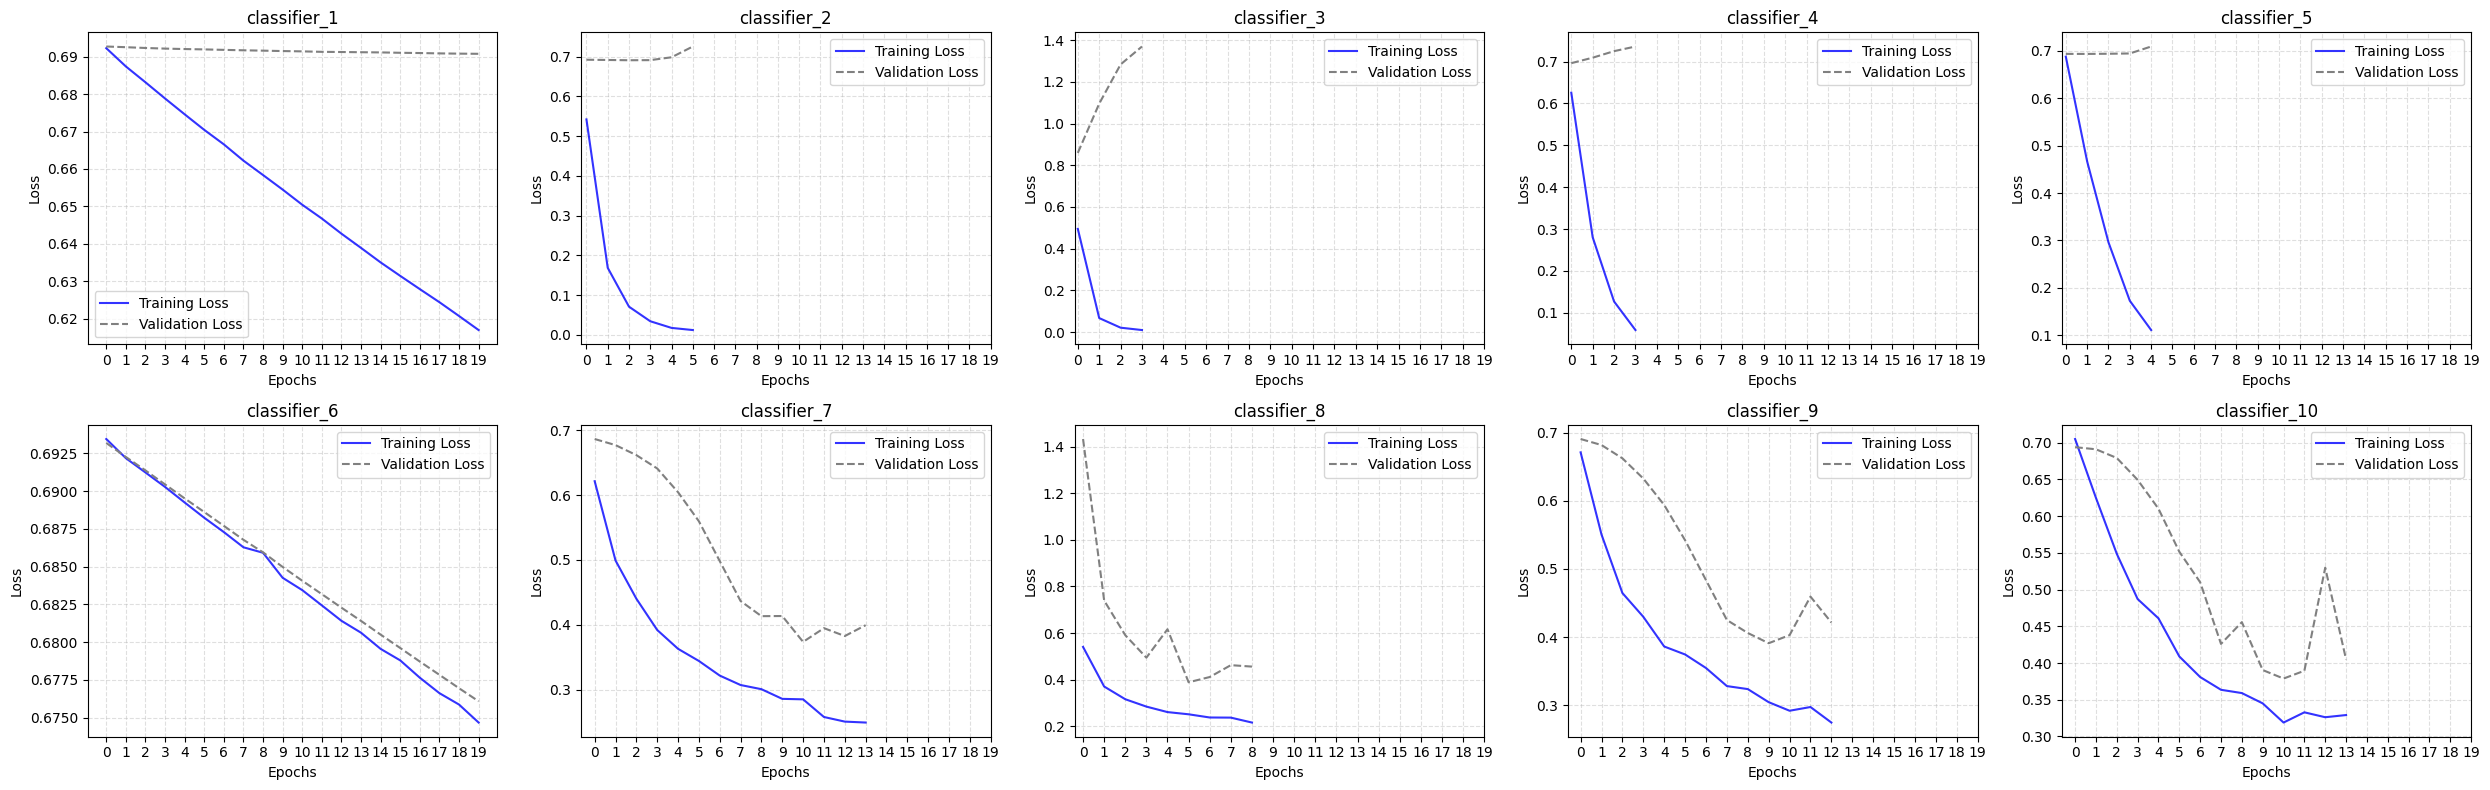

In [ ]:
# Creating a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(25, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterating over the training results of the classifiers
for key, value in training_results.items():

    # Getting the current plot
    ax = axes[int(key.split("_")[1]) - 1]

    # Plotting the lines
    ax.plot(
        value["training_losses"],
        label="Training Loss",
        linestyle="-",
        alpha=0.8,
        color="blue",
    )
    ax.plot(
        value["validation_losses"],
        label="Validation Loss",
        linestyle="--",
        color="grey",
    )

    # Setting plot parameters
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_xticks(list(range(epochs)))
    ax.set_title(key)
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()

In [ ]:
print(
    f"Best validation loss for classifier_7: {round(training_results['classifier_7']['validation_losses'][10], 4)}"
)
print(
    f"Best validation loss for classifier_10: {round(training_results['classifier_10']['validation_losses'][10], 4)}"
)

Best validation loss for classifier_7: 0.3737
Best validation loss for classifier_10: 0.3789


After testing multiple MLP classifiers with different parameter values and text representations and analyzing the training loss and validation loss curves according to the above plots, classifier_7 emerged as the best model, achieving a validation loss of 0.3737 at epoch 11, slightly lower than the best one of classifier_10

Use of the k-Nearest Neighbors (k-NN) classifier for classifying movie reviews

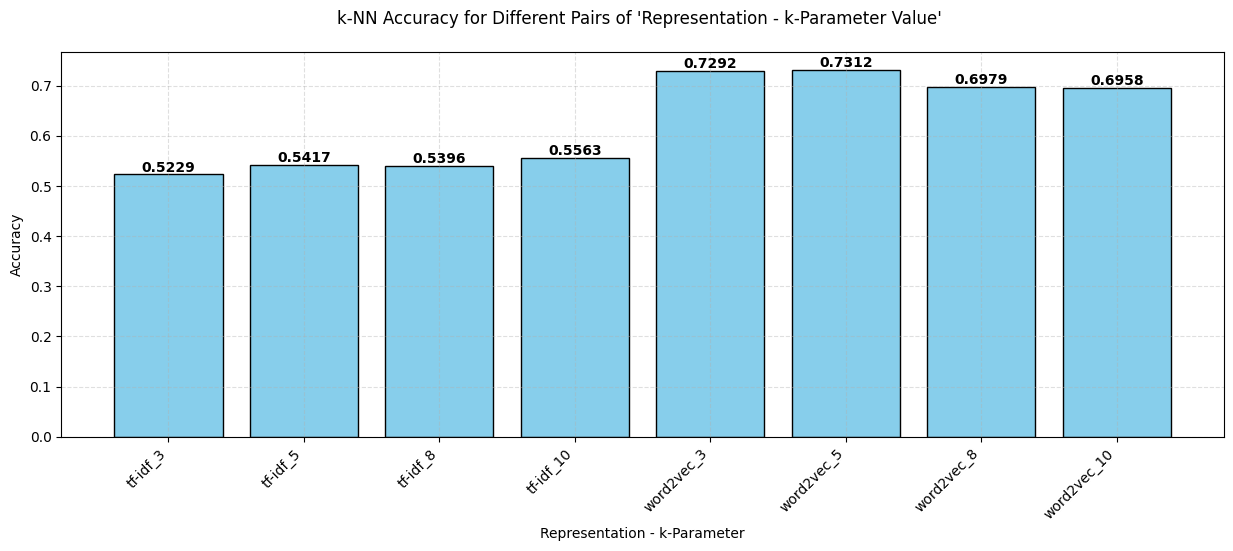

In [ ]:
# List of k-parameter values to test
k_values = [3, 5, 8, 10]

# Initializing a dictionary to keep all the computed accuracies
accuracies = {}

# Iterating over the different types of representation
for representation in ["tf-idf", "word2vec"]:

    # Getting the desired representation
    if representation == "tf-idf":

        # TF-IDF
        reviews_training_repr = reviews_training_tfidf
        reviews_validation_repr = reviews_validation_tfidf

    else:

        # Word2Vec
        reviews_training_repr = reviews_training_word2vec
        reviews_validation_repr = reviews_validation_word2vec

    # Iterating over the k-parameter values
    for k_value in k_values:

        # Initializing the k-NN classifier
        knn_classifier = KNeighborsClassifier(n_neighbors=k_value)

        # Training
        knn_classifier.fit(reviews_training_repr, categories_training)

        # Predicting
        knn_predictions = knn_classifier.predict(reviews_validation_repr)

        # Computing accuracy
        accuracies[f"{representation}_{k_value}"] = round(
            accuracy_score(categories_validation, knn_predictions), 4
        )


# Showing the results


# Creating a figure
plt.figure(figsize=(15, 5))

# Creating a bar plot
bars = plt.bar(
    list(accuracies.keys()),
    list(accuracies.values()),
    color="skyblue",
    edgecolor="black",
)

# Setting plot parameters
plt.xlabel("Representation - k-Parameter")
plt.ylabel("Accuracy")
plt.title(
    "k-NN Accuracy for Different Pairs of 'Representation - k-Parameter Value' ",
    pad=20
)
plt.xticks(rotation=45, ha="right")
plt.grid(True, which="both", linestyle="--", linewidth=0.8, alpha=0.4)

# Iterating over the bars
for bar in bars:

    # Getting the height/value
    height = bar.get_height()

    # Adding the value on top of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# Showing the plot
plt.show()

As we can see from the bar chart above, the best representation is the Word2Vec embeddings and the best k-parameter value is 5

Use the best vesrion of the k-Nearest Neighbors classifier and compute its classification scores

In [ ]:
# Initializing the k-NN classifier
best_knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Training
best_knn_classifier.fit(reviews_training_word2vec, categories_training)

# Predicting categories
training_knn_predictions = best_knn_classifier.predict(reviews_training_word2vec)
validation_knn_predictions = best_knn_classifier.predict(reviews_validation_word2vec)
test_knn_predictions = best_knn_classifier.predict(reviews_test_word2vec)

# Predicting probabilities
training_knn_probs = best_knn_classifier.predict_proba(reviews_training_word2vec)
validation_knn_probs = best_knn_classifier.predict_proba(reviews_validation_word2vec)
test_knn_probs = best_knn_classifier.predict_proba(reviews_test_word2vec)

# Computing classification scores for the training dataset
training_classification_scores_knn = compute_classification_scores(
    categories_training, training_knn_predictions, training_knn_probs[:, 1]
)

# Computing classification scores for the validation dataset
validation_classification_scores_knn = compute_classification_scores(
    categories_validation, validation_knn_predictions, validation_knn_probs[:, 1]
)

# Computing classification scores for the test dataset
test_classification_scores_knn = compute_classification_scores(
    categories_test, test_knn_predictions, test_knn_probs[:, 1]
)

Use of a majority classifier to classify movie reviews

In [ ]:
# Counting the occurrences of each class/category in the training dataset
categories_occurrence = Counter(categories_training)

# Finding the most frequent category
majority_category = categories_occurrence.most_common(1)[0][0]

# Computing the predictions for each dataset
training_majority_predictions = [majority_category] * len(categories_training)
validation_majority_predictions = [majority_category] * len(categories_validation)
test_majority_predictions = [majority_category] * len(categories_test)

# Computing classification scores for the training dataset
training_classification_scores_majority = compute_classification_scores(
    categories_training,
    training_majority_predictions,
    training_majority_predictions
)

# Computing classification scores for the validation dataset
validation_classification_scores_majority = compute_classification_scores(
    categories_validation,
    validation_majority_predictions,
    validation_majority_predictions,
)

# Computing classification scores for the test dataset
test_classification_scores_majority = compute_classification_scores(
    categories_test,
    test_majority_predictions,
    test_majority_predictions
)

Display the classification scores of all classifiers on all datasets (training, validation, test)

In [ ]:
# Creating the first level of headers
table_headers_level_1 = [
    "",
    "\033[1mMLP Classifier\033[0m",
    "",
    "",
    "",
    "\033[1mk-NN Classifier\033[0m",
    "",
    "",
    "",
    "\033[1mMajority Classifier\033[0m",
    "",
    "",
    "",
]

# Creating the second level of headers
table_headers_level_2 = [
    "",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
    "\033[1mPrecision\033[0m",
    "\033[1mRecall\033[0m",
    "\033[1mf1-Score\033[0m",
    "\033[1mPrecission-Recall AUC Score\033[0m",
]

# Creating the table values for the training dataset
table_training_data = [
    [
        "neg",
        round(training_results["classifier_7"]["training_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_7"]["training_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_7"]["training_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_7"]["training_scores"]["neg"]["precision-recall-auc"], 4),
        round(training_classification_scores_knn["neg"]["precision"], 4),
        round(training_classification_scores_knn["neg"]["recall"], 4),
        round(training_classification_scores_knn["neg"]["f1-score"], 4),
        round(training_classification_scores_knn["neg"]["precision-recall-auc"], 4),
        round(training_classification_scores_majority["neg"]["precision"], 4),
        round(training_classification_scores_majority["neg"]["recall"], 4),
        round(training_classification_scores_majority["neg"]["f1-score"], 4),
        round(training_classification_scores_majority["neg"]["precision-recall-auc"], 4)
    ],
    [
        "pos",
        round(training_results["classifier_7"]["training_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_7"]["training_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_7"]["training_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_7"]["training_scores"]["pos"]["precision-recall-auc"], 4),
        round(training_classification_scores_knn["pos"]["precision"], 4),
        round(training_classification_scores_knn["pos"]["recall"], 4),
        round(training_classification_scores_knn["pos"]["f1-score"], 4),
        round(training_classification_scores_knn["pos"]["precision-recall-auc"], 4),
        round(training_classification_scores_majority["pos"]["precision"], 4),
        round(training_classification_scores_majority["pos"]["recall"], 4),
        round(training_classification_scores_majority["pos"]["f1-score"], 4),
        round(training_classification_scores_majority["pos"]["precision-recall-auc"], 4)
    ],
    [
        "macro-average",
        round(training_results["classifier_7"]["training_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_7"]["training_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_7"]["training_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_7"]["training_scores"]["macro avg"]["precision-recall-auc"], 4),
        round(training_classification_scores_knn["macro avg"]["precision"], 4),
        round(training_classification_scores_knn["macro avg"]["recall"], 4),
        round(training_classification_scores_knn["macro avg"]["f1-score"], 4),
        round(training_classification_scores_knn["macro avg"]["precision-recall-auc"], 4),
        round(training_classification_scores_majority["macro avg"]["precision"], 4),
        round(training_classification_scores_majority["macro avg"]["recall"], 4),
        round(training_classification_scores_majority["macro avg"]["f1-score"], 4),
        round(training_classification_scores_majority["macro avg"]["precision-recall-auc"], 4)
    ],
]

# Creating the table values for the validation dataset
table_validation_data = [
    [
        "neg",
        round(training_results["classifier_7"]["validation_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_7"]["validation_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_7"]["validation_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_7"]["validation_scores"]["neg"]["precision-recall-auc"], 4),
        round(validation_classification_scores_knn["neg"]["precision"], 4),
        round(validation_classification_scores_knn["neg"]["recall"], 4),
        round(validation_classification_scores_knn["neg"]["f1-score"], 4),
        round(validation_classification_scores_knn["neg"]["precision-recall-auc"], 4),
        round(validation_classification_scores_majority["neg"]["precision"], 4),
        round(validation_classification_scores_majority["neg"]["recall"], 4),
        round(validation_classification_scores_majority["neg"]["f1-score"], 4),
        round(validation_classification_scores_majority["neg"]["precision-recall-auc"], 4)
    ],
    [
        "pos",
        round(training_results["classifier_7"]["validation_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_7"]["validation_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_7"]["validation_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_7"]["validation_scores"]["pos"]["precision-recall-auc"], 4),
        round(validation_classification_scores_knn["pos"]["precision"], 4),
        round(validation_classification_scores_knn["pos"]["recall"], 4),
        round(validation_classification_scores_knn["pos"]["f1-score"], 4),
        round(validation_classification_scores_knn["pos"]["precision-recall-auc"], 4),
        round(validation_classification_scores_majority["pos"]["precision"], 4),
        round(validation_classification_scores_majority["pos"]["recall"], 4),
        round(validation_classification_scores_majority["pos"]["f1-score"], 4),
        round(validation_classification_scores_majority["pos"]["precision-recall-auc"], 4)
    ],
    [
        "macro-average",
        round(training_results["classifier_7"]["validation_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_7"]["validation_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_7"]["validation_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_7"]["validation_scores"]["macro avg"]["precision-recall-auc"], 4),
        round(validation_classification_scores_knn["macro avg"]["precision"], 4),
        round(validation_classification_scores_knn["macro avg"]["recall"], 4),
        round(validation_classification_scores_knn["macro avg"]["f1-score"], 4),
        round(validation_classification_scores_knn["macro avg"]["precision-recall-auc"], 4),
        round(validation_classification_scores_majority["macro avg"]["precision"], 4),
        round(validation_classification_scores_majority["macro avg"]["recall"], 4),
        round(validation_classification_scores_majority["macro avg"]["f1-score"], 4),
        round(validation_classification_scores_majority["macro avg"]["precision-recall-auc"], 4)
    ],
]

# Creating the table values for the test dataset
table_test_data = [
    [
        "neg",
        round(training_results["classifier_7"]["test_scores"]["neg"]["precision"], 4),
        round(training_results["classifier_7"]["test_scores"]["neg"]["recall"], 4),
        round(training_results["classifier_7"]["test_scores"]["neg"]["f1-score"], 4),
        round(training_results["classifier_7"]["test_scores"]["neg"]["precision-recall-auc"], 4),
        round(test_classification_scores_knn["neg"]["precision"], 4),
        round(test_classification_scores_knn["neg"]["recall"], 4),
        round(test_classification_scores_knn["neg"]["f1-score"], 4),
        round(test_classification_scores_knn["neg"]["precision-recall-auc"], 4),
        round(test_classification_scores_majority["neg"]["precision"], 4),
        round(test_classification_scores_majority["neg"]["recall"], 4),
        round(test_classification_scores_majority["neg"]["f1-score"], 4),
        round(test_classification_scores_majority["neg"]["precision-recall-auc"], 4)
    ],
    [
        "pos",
        round(training_results["classifier_7"]["test_scores"]["pos"]["precision"], 4),
        round(training_results["classifier_7"]["test_scores"]["pos"]["recall"], 4),
        round(training_results["classifier_7"]["test_scores"]["pos"]["f1-score"], 4),
        round(training_results["classifier_7"]["test_scores"]["pos"]["precision-recall-auc"], 4),
        round(test_classification_scores_knn["pos"]["precision"], 4),
        round(test_classification_scores_knn["pos"]["recall"], 4),
        round(test_classification_scores_knn["pos"]["f1-score"], 4),
        round(test_classification_scores_knn["pos"]["precision-recall-auc"], 4),
        round(test_classification_scores_majority["pos"]["precision"], 4),
        round(test_classification_scores_majority["pos"]["recall"], 4),
        round(test_classification_scores_majority["pos"]["f1-score"], 4),
        round(test_classification_scores_majority["pos"]["precision-recall-auc"], 4)
    ],
    [
        "macro-average",
        round(training_results["classifier_7"]["test_scores"]["macro avg"]["precision"], 4),
        round(training_results["classifier_7"]["test_scores"]["macro avg"]["recall"], 4),
        round(training_results["classifier_7"]["test_scores"]["macro avg"]["f1-score"], 4),
        round(training_results["classifier_7"]["test_scores"]["macro avg"]["precision-recall-auc"], 4),
        round(test_classification_scores_knn["macro avg"]["precision"], 4),
        round(test_classification_scores_knn["macro avg"]["recall"], 4),
        round(test_classification_scores_knn["macro avg"]["f1-score"], 4),
        round(test_classification_scores_knn["macro avg"]["precision-recall-auc"], 4),
        round(test_classification_scores_majority["macro avg"]["precision"], 4),
        round(test_classification_scores_majority["macro avg"]["recall"], 4),
        round(test_classification_scores_majority["macro avg"]["f1-score"], 4),
        round(test_classification_scores_majority["macro avg"]["precision-recall-auc"], 4)
    ],
]

# Showing the classification scores for the training dataset

print(f"\033[1m{'Training Dataset':^200}\033[0m")
print()
print(
    tabulate(
        [table_headers_level_2] + table_training_data,
        headers=table_headers_level_1,
        tablefmt="rounded_grid",
    )
)

print()

# Showing the classification scores for the validation dataset

print(f"\033[1m{'Validation Dataset':^200}\033[0m")
print()
print(
    tabulate(
        [table_headers_level_2] + table_validation_data,
        headers=table_headers_level_1,
        tablefmt="rounded_grid",
    )
)

print()

# Showing the classification scores for the test dataset

print(f"\033[1m{'Test Dataset':^200}\033[0m")
print()
print(
    tabulate(
        [table_headers_level_2] + table_test_data,
        headers=table_headers_level_1,
        tablefmt="rounded_grid",
    )
)

                                                                                            Training Dataset                                                                                            

╭───────────────┬──────────────────┬────────┬──────────┬─────────────────────────────┬───────────────────┬────────┬──────────┬─────────────────────────────┬───────────────────────┬────────┬──────────┬─────────────────────────────╮
│               │ MLP Classifier   │        │          │                             │ k-NN Classifier   │        │          │                             │ Majority Classifier   │        │          │                             │
├───────────────┼──────────────────┼────────┼──────────┼─────────────────────────────┼───────────────────┼────────┼──────────┼─────────────────────────────┼───────────────────────┼────────┼──────────┼─────────────────────────────┤
│               │ Precision        │ Recall │ f1-Score │ Precission-Recall AUC Score │ Precision         